# Cleansing Data
Tujuannya: membuat teks bersih, konsisten, dan siap diolah ke model.  
Apa yang akan kita lakukan:  
Ubah semua teks menjadi huruf kecil.  
Hapus karakter non-alfabet (angka dan tanda baca yang tidak penting).  
Hilangkan spasi berlebihan.  
Opsional: hilangkan stopwords agar hanya kata penting yang tersisa.

In [27]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('/content/WELFake_Dataset.csv')
# Label (0 = fake and 1 = real
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


## Untuk data yang 0 kita drop

In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df['title'] = df['title'].fillna('')
df = df.dropna(subset=['text'])

## bikin fungsi untuk menghapus stop word dan melakukan lemmatize

In [6]:
def clean_text(text):
    # ubah ke huruf kecil
    text = text.lower()
    # hapus karakter non-alfabet
    text = re.sub(r'[^a-z\s]', '', text)
    # hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    # hilangkan stopwords dan lemitaze
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

In [7]:
# 3. Terapkan ke kolom teks
df['clean_text'] = df['title'] + ' ' + df['text']
df['clean_text'] = df['clean_text'].apply(clean_text)

In [8]:
# 4. Lihat hasilnya
print(df[['text', 'clean_text']].head())

                                                text  \
0  No comment is expected from Barack Obama Membe...   
1     Did they post their votes for Hillary already?   
2   Now, most of the demonstrators gathered last ...   
3  A dozen politically active pastors came here f...   
4  The RS-28 Sarmat missile, dubbed Satan 2, will...   

                                          clean_text  
0  law enforcement high alert following threat co...  
1                          post vote hillary already  
2  unbelievable obamas attorney general say charl...  
3  bobby jindal raised hindu us story christian c...  
4  satan russia unvelis image terrifying new supe...  


In [9]:
# pembagian data
X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# EDA

In [10]:
# 1. Info data
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       72095 non-null  object
 1   text        72095 non-null  object
 2   label       72095 non-null  int64 
 3   clean_text  72095 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB
None
title         0
text          0
label         0
clean_text    0
dtype: int64


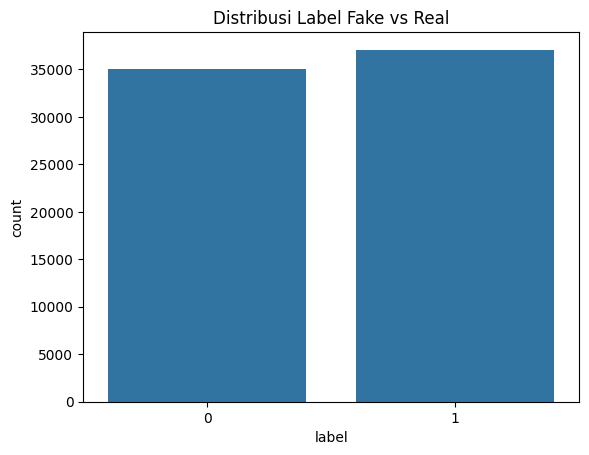

In [11]:
# 2. Distribusi label
sns.countplot(data=df, x='label')
plt.title('Distribusi Label Fake vs Real')
plt.show()

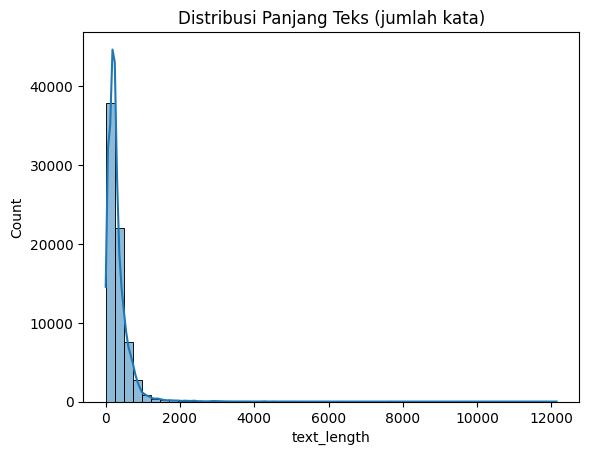

In [12]:
# 3. Panjang teks
df['text_length'] = df['clean_text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribusi Panjang Teks (jumlah kata)')
plt.show()

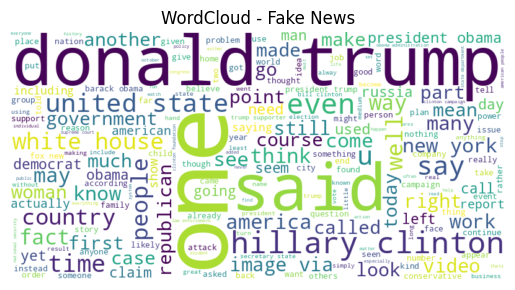

In [13]:
# 4. Wordcloud untuk Fake News
fake_text = " ".join(df[df['label']==1]['clean_text'].astype(str))
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Fake News')
plt.show()

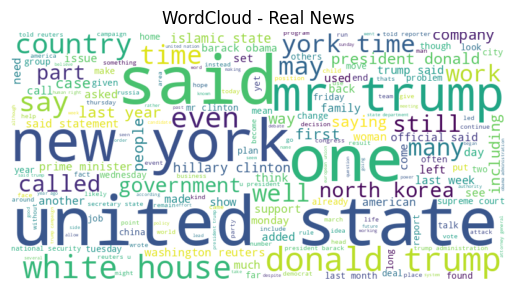

In [14]:
# 5. Wordcloud untuk Real News
real_text = " ".join(df[df['label']==0]['clean_text'].astype(str))
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Real News')
plt.show()

## Vektorisasi Teks

In [15]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Model ML Clasic untuk NLP

In [16]:
lr = LogisticRegression()
lr.fit(X_train_vec, y_train)
y_pred_lr = lr.predict(X_test_vec)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      7010
           1       0.95      0.95      0.95      7409

    accuracy                           0.95     14419
   macro avg       0.95      0.95      0.95     14419
weighted avg       0.95      0.95      0.95     14419



In [17]:
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))


Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      7010
           1       0.95      0.97      0.96      7409

    accuracy                           0.96     14419
   macro avg       0.96      0.96      0.96     14419
weighted avg       0.96      0.96      0.96     14419



In [18]:
# lama jadi tidak dijalankan
#svm = SVC()
#svm.fit(X_train_vec, y_train)
#y_pred_svm = svm.predict(X_test_vec)
#print("SVM:\n", classification_report(y_test, y_pred_svm))


In [19]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))


Naive Bayes:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      7010
           1       0.83      0.87      0.85      7409

    accuracy                           0.84     14419
   macro avg       0.84      0.84      0.84     14419
weighted avg       0.84      0.84      0.84     14419



In [20]:
dt = DecisionTreeClassifier()
dt.fit(X_train_vec, y_train)
y_pred_dt = dt.predict(X_test_vec)
print("Decision Tree:\n", classification_report(y_test, y_pred_dt))


Decision Tree:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      7010
           1       0.93      0.95      0.94      7409

    accuracy                           0.93     14419
   macro avg       0.93      0.93      0.93     14419
weighted avg       0.93      0.93      0.93     14419



## Evaluasi Model

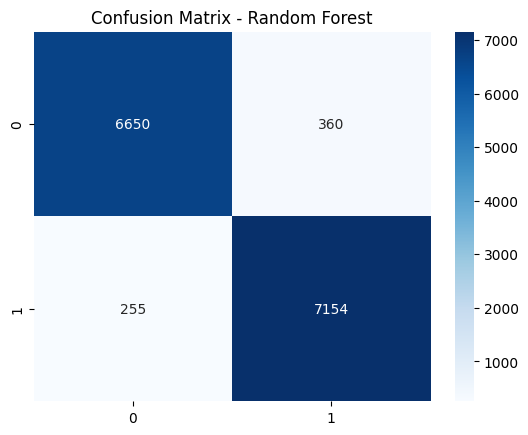

In [29]:
# Matriks Confusion untuk Logistic Regression
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

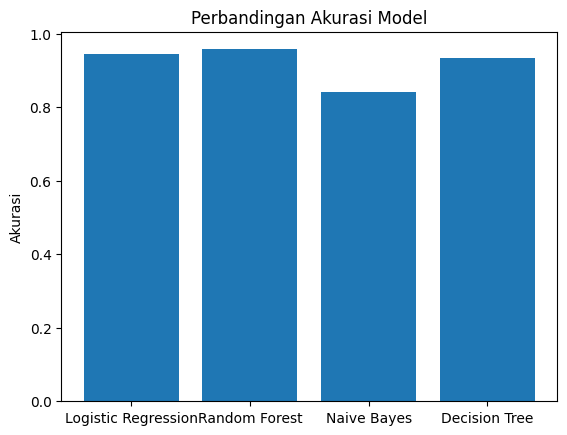

In [24]:
# Mebandingkan Akurasi model
models = ['Logistic Regression', 'Random Forest',
          #'SVM',
          'Naive Bayes', 'Decision Tree']
accuracies = [
    lr.score(X_test_vec, y_test),
    rf.score(X_test_vec, y_test),
    #svm.score(X_test_vec, y_test),
    nb.score(X_test_vec, y_test),
    dt.score(X_test_vec, y_test)
]

plt.bar(models, accuracies)
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Akurasi')
plt.show()

In [28]:
# Hitung akurasi tiap model
model_names = ['Logistic Regression', 'Random Forest',
               #'SVM',
               'Naive Bayes', 'Decision Tree']
models = [lr, rf,
          #svm,
          nb, dt]

accuracies = []
for model in models:
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Buat DataFrame
accuracy_table = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

# Tampilkan tabel
print(accuracy_table)

                 Model  Accuracy
0  Logistic Regression  0.945766
1        Random Forest  0.957348
2          Naive Bayes  0.840141
3        Decision Tree  0.934045


## Pilih dari Model Terbaik

In [31]:
best_model = rf  # Ganti dengan model terbaik yang dipilih
def predict_fake_news(text):
    text_cleaned = clean_text(text)
    text_vec = vectorizer.transform([text_cleaned])
    prediction = best_model.predict(text_vec)
    return 'Real' if prediction == 1 else 'Fake'

# Contoh penggunaan
print(predict_fake_news("No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:39 minute clip from the radio show can be heard here. It was provided to Breitbart Texas by someone who would like to be referred to as  Hannibal.  He has already received death threats as a result of interrupting #FYF911 conference calls.An unidentified black man said  when those mother f**kers are by themselves, that s when when we should start f***ing them up. Like they do us, when a bunch of them ni**ers takin  one of us out, that s how we should roll up.  He said,  Cause we already roll up in gangs anyway. There should be six or seven black mother f**ckers, see that white person, and then lynch their ass. Let s turn the tables. They conspired that if  cops started losing people,  then  there will be a state of emergency. He speculated that one of two things would happen,  a big-ass [R s?????] war,  or  ni**ers, they are going to start backin  up. We are already getting killed out here so what the f**k we got to lose? Sunshine could be heard saying,  Yep, that s true. That s so f**king true. He said,  We need to turn the tables on them. Our kids are getting shot out here. Somebody needs to become a sacrifice on their side.He said,  Everybody ain t down for that s**t, or whatever, but like I say, everybody has a different position of war.  He continued,  Because they don t give a f**k anyway.  He said again,  We might as well utilized them for that s**t and turn the tables on these n**ers. He said, that way  we can start lookin  like we ain t havin  that many casualties, and there can be more causalities on their side instead of ours. They are out their killing black people, black lives don t matter, that s what those mother f**kers   so we got to make it matter to them. Find a mother f**ker that is alone. Snap his ass, and then f***in hang him from a damn tree. Take a picture of it and then send it to the mother f**kers. We  just need one example,  and  then people will start watchin .  This will turn the tables on s**t, he said. He said this will start  a trickle-down effect.  He said that when one white person is hung and then they are just  flat-hanging,  that will start the  trickle-down effect.  He continued,  Black people are good at starting trends. He said that was how  to get the upper-hand. Another black man spoke up saying they needed to kill  cops that are killing us. The first black male said,  That will be the best method right there. Breitbart Texas previously reported how Sunshine was upset when  racist white people  infiltrated and disrupted one of her conference calls. She subsequently released the phone number of one of the infiltrators. The veteran immediately started receiving threatening calls.One of the #F***YoFlag movement supporters allegedly told a veteran who infiltrated their publicly posted conference call,  We are going to rape and gut your pregnant wife, and your f***ing piece of sh*t unborn creature will be hung from a tree. Breitbart Texas previously encountered Sunshine at a Sandra Bland protest at the Waller County Jail in Texas, where she said all white people should be killed. She told journalists and photographers,  You see this nappy-ass hair on my head?   That means I am one of those more militant Negroes.  She said she was at the protest because  these redneck mother-f**kers murdered Sandra Bland because she had nappy hair like me. #FYF911 black radicals say they will be holding the  imperial powers  that are actually responsible for the terrorist attacks on September 11th accountable on that day, as reported by Breitbart Texas. There are several websites and Twitter handles for the movement. Palmetto Star  describes himself as one of the head organizers. He said in a YouTube video that supporters will be burning their symbols of  the illusion of their superiority,  their  false white supremacy,  like the American flag, the British flag, police uniforms, and Ku Klux Klan hoods.Sierra McGrone or  Nocturnus Libertus  posted,  you too can help a young Afrikan clean their a** with the rag of oppression.  She posted two photos, one that appears to be herself, and a photo of a black man, wiping their naked butts with the American flag.For entire story: Breitbart News"))

Real
